# Java Development Tool Bug Classification

In [2]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

tqdm.pandas()
sns.set()
pd.set_option('display.max_colwidth', 50)

BASE_PATH = Path("../DATASETS/java-bug/")

In [4]:
df = pd.read_csv(BASE_PATH/'eclipse_jdt.csv.gz')

### Analysing

In [5]:
df.head(2)

,Issue_id,Priority,Component,Duplicated_issue,Title,Description,Status,Resolution,Version,Created_time,Resolved_time
0,1518,P1,Debug,NaN,Icons needed for actions (1GI5UXW),JGS (8/8/01 5:20:19 PM); \tWe need enabled; di...,VERIFIED,FIXED,2.0,2001-10-10 22:14:00 -0400,2001-10-18 11:51:14 -0400
1,1519,P3,Debug,NaN,README: Hit count not reset (1GET20Y),JGS (6/4/01 11:43:47 AM); \tSet a breakpoint i...,RESOLVED,WORKSFORME,2.0,2001-10-10 22:14:00 -0400,2001-11-28 13:42:46 -0500


In [6]:
df.isna().sum() 

Issue_id                0
Priority                0
Component               0
Duplicated_issue    37608
Title                   0
Description            43
Status                  0
Resolution              0
Version                 0
Created_time            0
Resolved_time           0
dtype: int64

In [7]:
print("Length of the dataset: ", len(df))

Length of the dataset:  45296


In [8]:
print(f"So, we've {len(df) - 37608} duplicate issues")

So, we've 7688 duplicate issues


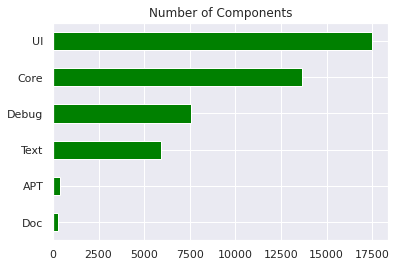

In [9]:
ax = df['Component'].value_counts().plot.barh(title = 'Number of Components', color = 'green')
ax.invert_yaxis()

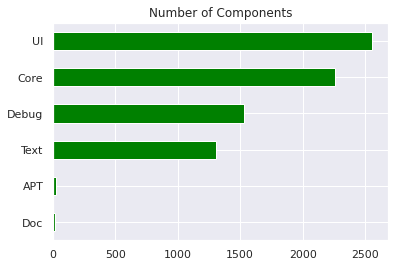

In [10]:
# just check value count of duplicate issues

duplicate = df[~df['Duplicated_issue'].isna()]['Component']
duplicate.value_counts().plot.barh(title = 'Number of Components', color = 'green').invert_yaxis()

In [11]:
df.iloc[duplicate.index[0]].T

Issue_id                                                         1522
Priority                                                           P2
Component                                                       Debug
Duplicated_issue                                                 1663
Title               Feature: use #toString to display variable val...
Description         DW (9/27/00 11:12:31 AM); \tCurrently; the typ...
Status                                                       RESOLVED
Resolution                                                  DUPLICATE
Version                                                           2.0
Created_time                                2001-10-10 22:14:00 -0400
Resolved_time                               2001-10-17 10:17:47 -0400
Name: 4, dtype: object

In [12]:
df.iloc[1663].T

Issue_id                                                         5357
Priority                                                           P3
Component                                                       Debug
Duplicated_issue                                                  NaN
Title                   Feature: Action to select line for evaluation
Description         To simplify the execution of the recently ente...
Status                                                       RESOLVED
Resolution                                                    WONTFIX
Version                                                           2.0
Created_time                                2001-10-30 11:04:00 -0500
Resolved_time                               2002-07-15 16:07:14 -0400
Name: 1663, dtype: object

### Data Preparation

In [13]:
import html
import re

def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [14]:
df = df[['Title', 'Description', 'Component']]
df.dropna(inplace=True)
df['text'] = df['Title'] + ' ' + df['Description']
df = df.drop(columns=['Title','Description'])

In [15]:
df.columns

Index(['Component', 'text'], dtype='object')

In [16]:
df['text'] = df['text'].progress_apply(clean)

100%|██████████| 45253/45253 [00:06<00:00, 6832.66it/s]


In [17]:
df = df[df['text'].str.len() > 50]
df.sample(4)

,Component,text
3168,Debug,TimeoutException during terminate When we get ...
7295,UI,show in packages view on methods works only if...
14646,UI,Externalize Strings cell editors editing broke...
12989,Debug,Present logical view of Java objects in debugg...


### Train Test Split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
df = df.groupby('Component', as_index=False).apply(
                                    pd.DataFrame.sample, 
                                    frac = .2, 
                                    random_state = 21)

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(
                                                df['text'],
                                                df['Component'],
                                                test_size=.2,
                                                stratify=df['Component'],
                                                random_state=42
                                            )

In [21]:
print("Size of Training Data: ", X_train.shape[0])
print("Size of Testing Data: ", X_test.shape[0])

Size of Training Data:  7208
Size of Testing Data:  1803


### Training Model

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [24]:

clf = DummyClassifier(strategy='most_frequent')

clf.fit(X_train, Y_train)

Y_pred_baseline = clf.predict(X_test)

print()
print ('Accuracy Score of Base Model - ', accuracy_score(Y_test, Y_pred_baseline))
print()


Accuracy Score of Base Model -  0.38546866333887964



In [25]:

clf = DummyClassifier(strategy='most_frequent')

clf.fit(X_train, Y_train)

Y_pred_baseline = clf.predict(X_test)

print()
print ('Accuracy Score of Base Model - ', accuracy_score(Y_test, Y_pred_baseline))
print()


Accuracy Score of Base Model -  0.38546866333887964



In [26]:
tfidf = TfidfVectorizer(stop_words='english', min_df=5, ngram_range=(1, 6))
model = SVC(kernel="linear", C=1, probability=True, random_state=42)

In [27]:
model_pipeline = Pipeline(
            steps=[('tfidf', tfidf), 
                   ('model', model)
                  ]
            )

In [28]:
model_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 6),
                                 stop_words='english')),
                ('model',
                 SVC(C=1, kernel='linear', probability=True, random_state=42))])

In [30]:
Y_pred = model_pipeline.predict(X_test)

In [32]:
print("Test Accuracy Score : ", accuracy_score(Y_test, Y_pred))
print("Trian Accuracy Score: ", accuracy_score(Y_train, model_pipeline.predict(X_train)))

Test Accuracy Score :  0.7498613422074321
Trian Accuracy Score:  0.9134295227524972


In [81]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

         APT       0.83      0.31      0.45        16
        Core       0.73      0.77      0.75       545
       Debug       0.89      0.79      0.84       300
         Doc       0.62      0.42      0.50        12
        Text       0.67      0.51      0.58       235
          UI       0.74      0.81      0.77       695

    accuracy                           0.75      1803
   macro avg       0.75      0.60      0.65      1803
weighted avg       0.75      0.75      0.75      1803



### Visualising Important features for each components

In [56]:
result = {'text': X_test, 'actual': Y_test, 'predicted': Y_pred}
result = pd.DataFrame(result)

result[result['actual'] != result['predicted']].head(4)

,text,actual,predicted
3,All types cache populated during start-up When...,UI,Core
13,QualifiedNameReference#indexOfFirstFieldBindin...,Core,UI
14,Searching for Inner Classes gives bad search r...,Core,UI
17,Returns: oddly highlighted in Content Assist J...,UI,Text


In [57]:
result.iloc[3]['text']

'All types cache populated during start-up When restoring a crashed workspace the AllTypeCache Updater has shown-up ; during the start-up sequence before an event loop is active.; ; The suspicion is that this updating is triggered by a delta before the ; runnable that triggers the initial population is executed.; ; The solution we have discussed is that the all types cache should ignore ; deltas and not start updating before the runnable is executed.'

In [77]:
class_name = model.classes_.tolist()
print(class_name)

['APT', 'Core', 'Debug', 'Doc', 'Text', 'UI']


In [58]:
model_pipeline.predict_proba(pd.Series(result.iloc[3]['text']))

array([[0.00355295, 0.62874356, 0.06939986, 0.00398987, 0.01868298,
        0.27563078]])

In [61]:
prob = model_pipeline.predict_proba(X_test)

In [72]:
er = result.copy()

In [73]:
for i, c in enumerate(class_name):
  er[c] = prob[:, i]

In [79]:
er[["actual", "predicted"] + class_name].sample(4, random_state = 42)

,actual,predicted,APT,Core,Debug,Doc,Text,UI
832,Debug,Debug,0.001760,0.007375,0.963737,0.001066,0.001504,0.024557
613,Core,Core,0.123085,0.863278,0.001111,0.001061,0.009430,0.002036
1582,Core,UI,0.005588,0.173184,0.095960,0.004657,0.146162,0.574449
162,Core,Core,0.001247,0.684893,0.091159,0.000875,0.020846,0.200981


In [82]:
er['max_prob'] = er[class_name].max(axis=1)

In [83]:
correct = er[er['actual'] == er['predicted']]
wrong = er[er['actual'] != er['predicted']]

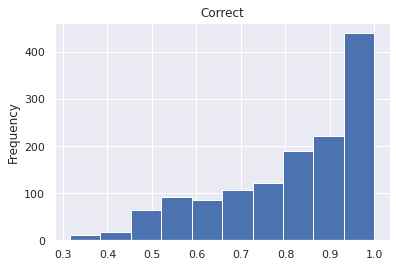

In [89]:
correct['max_prob'].plot.hist(title = 'Correct');

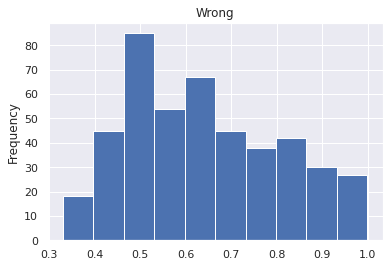

In [91]:
wrong['max_prob'].plot.hist(title = 'Wrong');

In [92]:
# We can see that in the case of correct predictions, the model often decided with high
# probabilities, whereas the probabilities were considerably lower when the decision
# was wrong.

In [94]:
high = er[er["max_prob"] > 0.8]
print(classification_report(high["actual"], high["predicted"]))

              precision    recall  f1-score   support

         APT       0.83      0.71      0.77         7
        Core       0.92      0.90      0.91       282
       Debug       0.92      0.94      0.93       218
         Doc       0.62      0.83      0.71         6
        Text       0.80      0.72      0.76        78
          UI       0.88      0.91      0.89       340

    accuracy                           0.90       931
   macro avg       0.83      0.84      0.83       931
weighted avg       0.90      0.90      0.90       931



In [95]:
print(classification_report(er["actual"], er["predicted"]))

              precision    recall  f1-score   support

         APT       0.83      0.31      0.45        16
        Core       0.73      0.77      0.75       545
       Debug       0.89      0.79      0.84       300
         Doc       0.62      0.42      0.50        12
        Text       0.67      0.51      0.58       235
          UI       0.74      0.81      0.77       695

    accuracy                           0.75      1803
   macro avg       0.75      0.60      0.65      1803
weighted avg       0.75      0.75      0.75      1803



In [103]:
class_name

['APT', 'Core', 'Debug', 'Doc', 'Text', 'UI']

In [154]:
def plot_coef(coef, top_words = 20, title = None, figsize = (4, 6), **kwargs):
  vocabulary_position = coef.argsort()
  vocabulary = tfidf.get_feature_names_out()

  top_positive_coef = vocabulary_position[-top_words:].tolist()
  top_negative_coef = vocabulary_position[:top_words].tolist()

  core = pd.DataFrame([[vocabulary[c], coef[c]]
                      for c in top_positive_coef + top_negative_coef],
                    columns=["feature", "coefficient"]).sort_values("coefficient")

  core.set_index("feature").plot.barh(figsize=figsize, title = title, **kwargs);

In [155]:
c = model.coef_

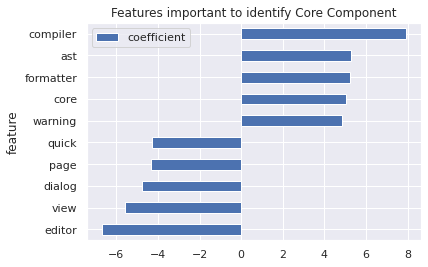

In [156]:
core_coef = (c[5] + c[6] + c[7] + c[8] - c[0]).A[0]
plot_coef(core_coef, top_words=5, title = 'Features important to identify Core Component', figsize=(6, 4))

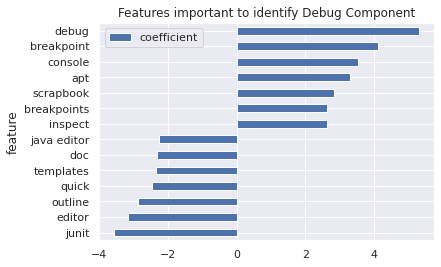

In [160]:
debug_coef = (c[1] + c[5] + c[9] + c[10] + c[11]).A[0]

plot_coef(debug_coef, top_words=7, title = 'Features important to identify Debug Component', figsize=(6, 4))

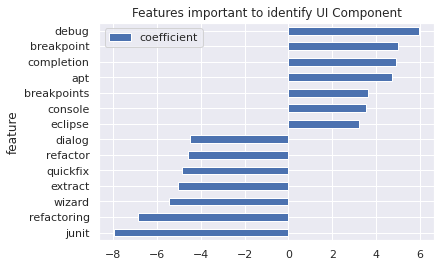

In [159]:
ui_coef = (c[4] + c[8] + c[11] + c[13] + c[14]).A[0]

plot_coef(ui_coef, top_words=7, title = 'Features important to identify UI Component', figsize=(6, 4))